In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

2024-09-08 15:06:51.842026: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 15:06:51.894354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 15:06:52.613501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/EfficientNetV2L'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
# Parameters
img_height, img_width = 224, 224  # InceptionV3 requires images of size 299x299
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [6]:
# Function to create train, validation, and test splits
def create_splits():
    try:
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(validation_dir):
            os.makedirs(validation_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
    
        for class_name in os.listdir(dataset_dir):        
            train_class_path = os.path.join(train_dir, class_name)        
            if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)        
            
            test_class_path = os.path.join(test_dir, class_name)        
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)        
    
            validation_class_dir = os.path.join(validation_dir, class_name)       
            if not os.path.exists(validation_class_dir):
                os.makedirs(validation_class_dir)        
        
        for class_name in os.listdir(dataset_dir):        
            class_path = os.path.join(dataset_dir, class_name)
            
            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)
                train_split = int(train_ratio * len(images))
                validation_split = int(validation_ratio * len(images))
                
                train_images = images[:train_split]
                validation_images = images[train_split:train_split + validation_split]
                test_images = images[train_split + validation_split:]
    
                for image in train_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
                for image in validation_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
                for image in test_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))
    except Exception as err:
        print("Error:", str(err))


In [7]:
# Split the dataset
create_splits()

In [8]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1418 images belonging to 5 classes.
Found 422 images belonging to 5 classes.
Found 444 images belonging to 5 classes.


In [11]:
# Load the EfficientNetV2L model pretrained on ImageNet
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-09-08 15:06:54.868087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46140 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-08 15:07:27.957927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-09-08 15:07:28.312431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-08 15:07:28.491909: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8c0d3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-08 15:07:28.491958: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-08 15:07:28.500966: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-08 15:07:28.673060: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 [==============================] - ETA: 0s - loss: 1.6987 - accuracy: 0.1926

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 51s 608ms/step - loss: 1.6987 - accuracy: 0.1926 - val_loss: 1.6102 - val_accuracy: 0.1923
Epoch 2/50
44/44 [==============================] - 21s 479ms/step - loss: 1.6430 - accuracy: 0.1962 - val_loss: 1.6092 - val_accuracy: 0.1995
Epoch 3/50
44/44 [==============================] - 19s 421ms/step - loss: 1.6551 - accuracy: 0.1782 - val_loss: 1.6092 - val_accuracy: 0.2139
Epoch 4/50
44/44 [==============================] - 22s 486ms/step - loss: 1.6406 - accuracy: 0.2078 - val_loss: 1.6089 - val_accuracy: 0.2091
Epoch 5/50
44/44 [==============================] - 19s 426ms/step - loss: 1.6344 - accuracy: 0.1962 - val_loss: 1.6096 - val_accuracy: 0.1995
Epoch 6/50
44/44 [==============================] - 19s 419ms/step - loss: 1.6398 - accuracy: 0.1876 - val_loss: 1.6094 - val_accuracy: 0.2019
Epoch 7/50
44/44 [==============================] - 19s 428ms/step - loss: 1.6305 - accuracy: 0.1984 - val_loss: 1.6103 - val_accuracy: 0.1875
Epoch 8/50

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 2s 140ms/step - loss: 1.6036 - accuracy: 0.2050
Test accuracy: 0.20


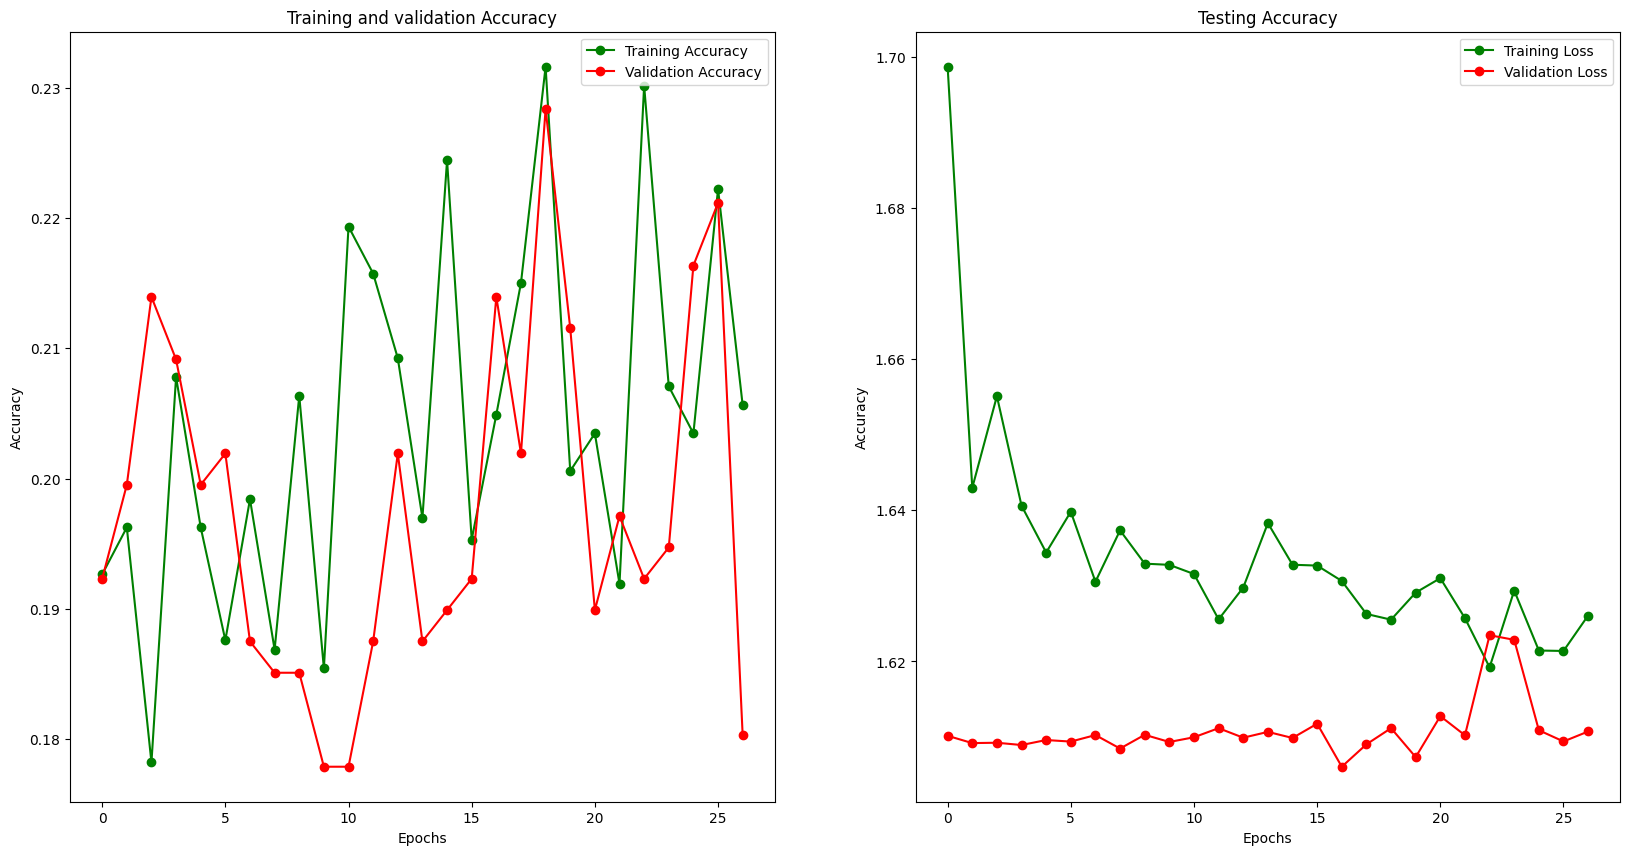

In [14]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

14/14 [==============================] - 6s 98ms/step


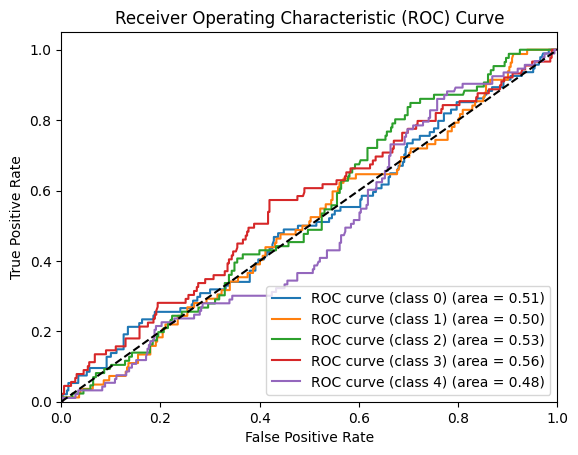

In [15]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 1 

In [16]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

14/14 [==============================] - 2s 109ms/step
Length of y_true: 422
Length of y_pred_classes: 422
Accuracy: 0.21
Precision: 0.25
Recall: 0.21
F1 Score: 0.21
F2 Score: 0.21


In [17]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 93ms/step
Length of y_true: 422
Length of y_pred: 422
Average AUC: 0.50


# Architecture No 2

In [18]:
# Load the EfficientNetV2L model pretrained on ImageNet
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True


top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 1.6620 - accuracy: 0.2056

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 50s 592ms/step - loss: 1.6620 - accuracy: 0.2056 - val_loss: 1.6092 - val_accuracy: 0.2188
Epoch 2/50
44/44 [==============================] - 21s 481ms/step - loss: 1.6713 - accuracy: 0.2013 - val_loss: 1.6088 - val_accuracy: 0.1971
Epoch 3/50
44/44 [==============================] - 21s 475ms/step - loss: 1.6505 - accuracy: 0.1912 - val_loss: 1.6084 - val_accuracy: 0.2212
Epoch 4/50
44/44 [==============================] - 21s 483ms/step - loss: 1.6261 - accuracy: 0.2186 - val_loss: 1.6081 - val_accuracy: 0.2188
Epoch 5/50
44/44 [==============================] - 21s 478ms/step - loss: 1.6469 - accuracy: 0.1883 - val_loss: 1.6079 - val_accuracy: 0.2452
Epoch 6/50
44/44 [==============================] - 22s 485ms/step - loss: 1.6317 - accuracy: 0.1999 - val_loss: 1.6075 - val_accuracy: 0.2332
Epoch 7/50
44/44 [==============================] - 21s 477ms/step - loss: 1.6293 - accuracy: 0.2186 - val_loss: 1.6064 - val_accuracy: 0.2596
Epoch 8/50

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 2s 106ms/step - loss: 1.6032 - accuracy: 0.2500
Test accuracy: 0.25


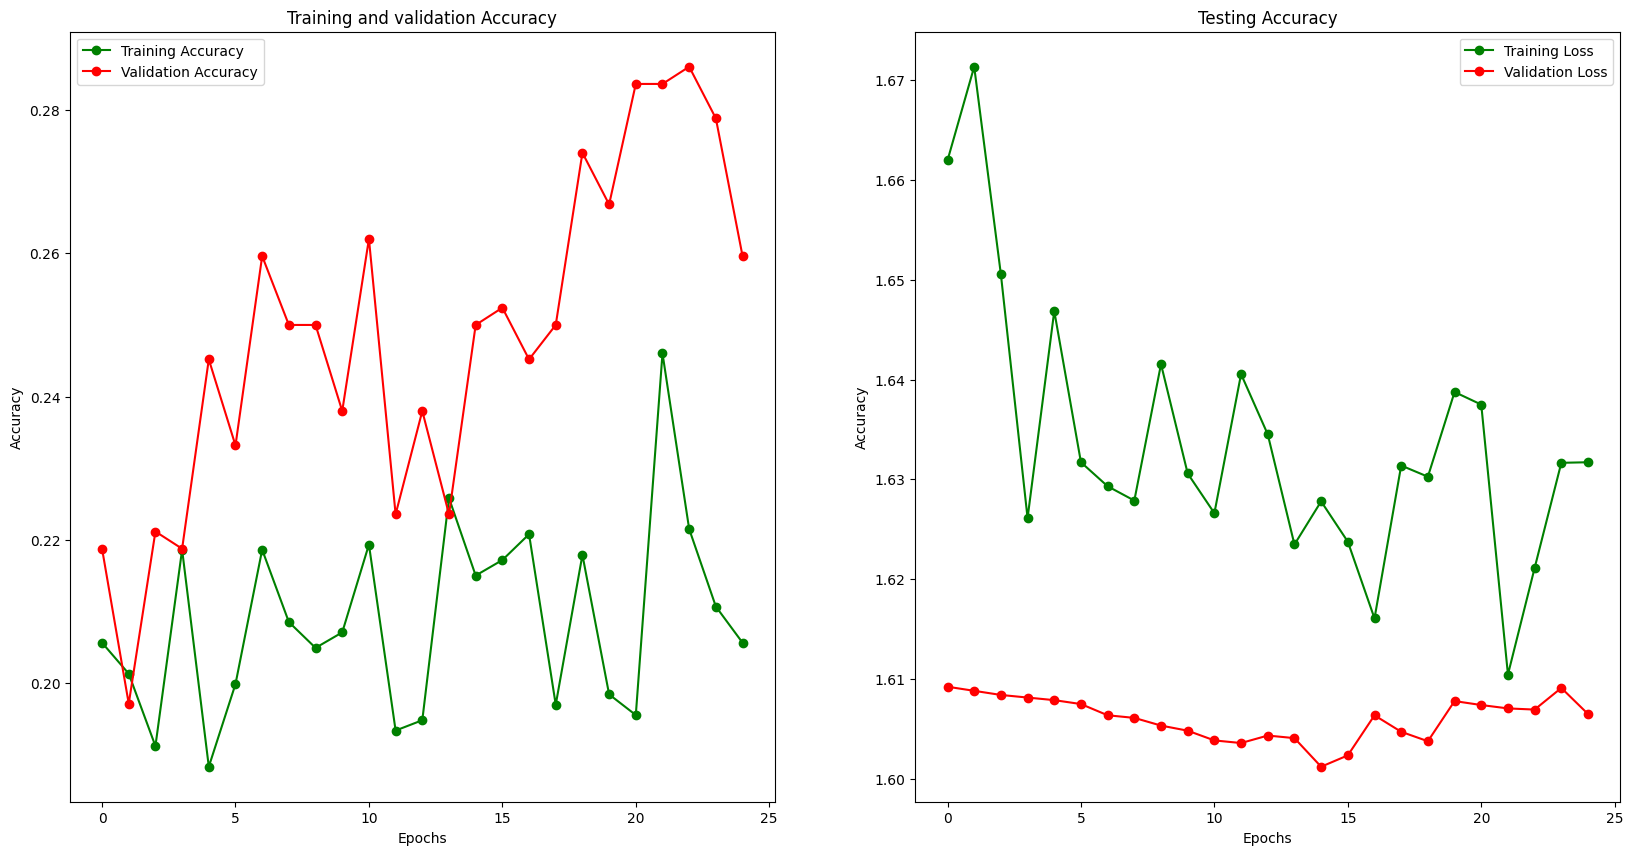

In [22]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

14/14 [==============================] - 8s 96ms/step


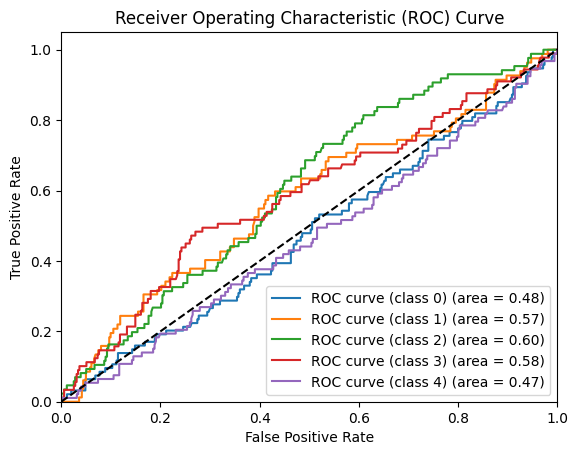

In [23]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 2 

In [24]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

14/14 [==============================] - 1s 94ms/step
Length of y_true: 422
Length of y_pred_classes: 422
Accuracy: 0.18
Precision: 0.18
Recall: 0.18
F1 Score: 0.16
F2 Score: 0.17


In [25]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 95ms/step
Length of y_true: 422
Length of y_pred: 422
Average AUC: 0.48


# Architecture No 4

In [26]:
# Load the EfficientNetV2L model pretrained on ImageNet
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [27]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-08 15:27:48.010402: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 [==============================] - ETA: 0s - loss: 1.7303 - accuracy: 0.1876

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 49s 591ms/step - loss: 1.7303 - accuracy: 0.1876 - val_loss: 1.6099 - val_accuracy: 0.2043
Epoch 2/50
44/44 [==============================] - 19s 419ms/step - loss: 1.7039 - accuracy: 0.2128 - val_loss: 1.6102 - val_accuracy: 0.1803
Epoch 3/50
44/44 [==============================] - 21s 482ms/step - loss: 1.6850 - accuracy: 0.2251 - val_loss: 1.6096 - val_accuracy: 0.1851
Epoch 4/50
44/44 [==============================] - 21s 479ms/step - loss: 1.6948 - accuracy: 0.2107 - val_loss: 1.6086 - val_accuracy: 0.1899
Epoch 5/50
44/44 [==============================] - 21s 482ms/step - loss: 1.7201 - accuracy: 0.2179 - val_loss: 1.6081 - val_accuracy: 0.2019
Epoch 6/50
44/44 [==============================] - 21s 475ms/step - loss: 1.6743 - accuracy: 0.2287 - val_loss: 1.6079 - val_accuracy: 0.1971
Epoch 7/50
44/44 [==============================] - 21s 486ms/step - loss: 1.6872 - accuracy: 0.2071 - val_loss: 1.6065 - val_accuracy: 0.1803
Epoch 8/50

In [28]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 2s 106ms/step - loss: 1.5957 - accuracy: 0.2162
Test accuracy: 0.22


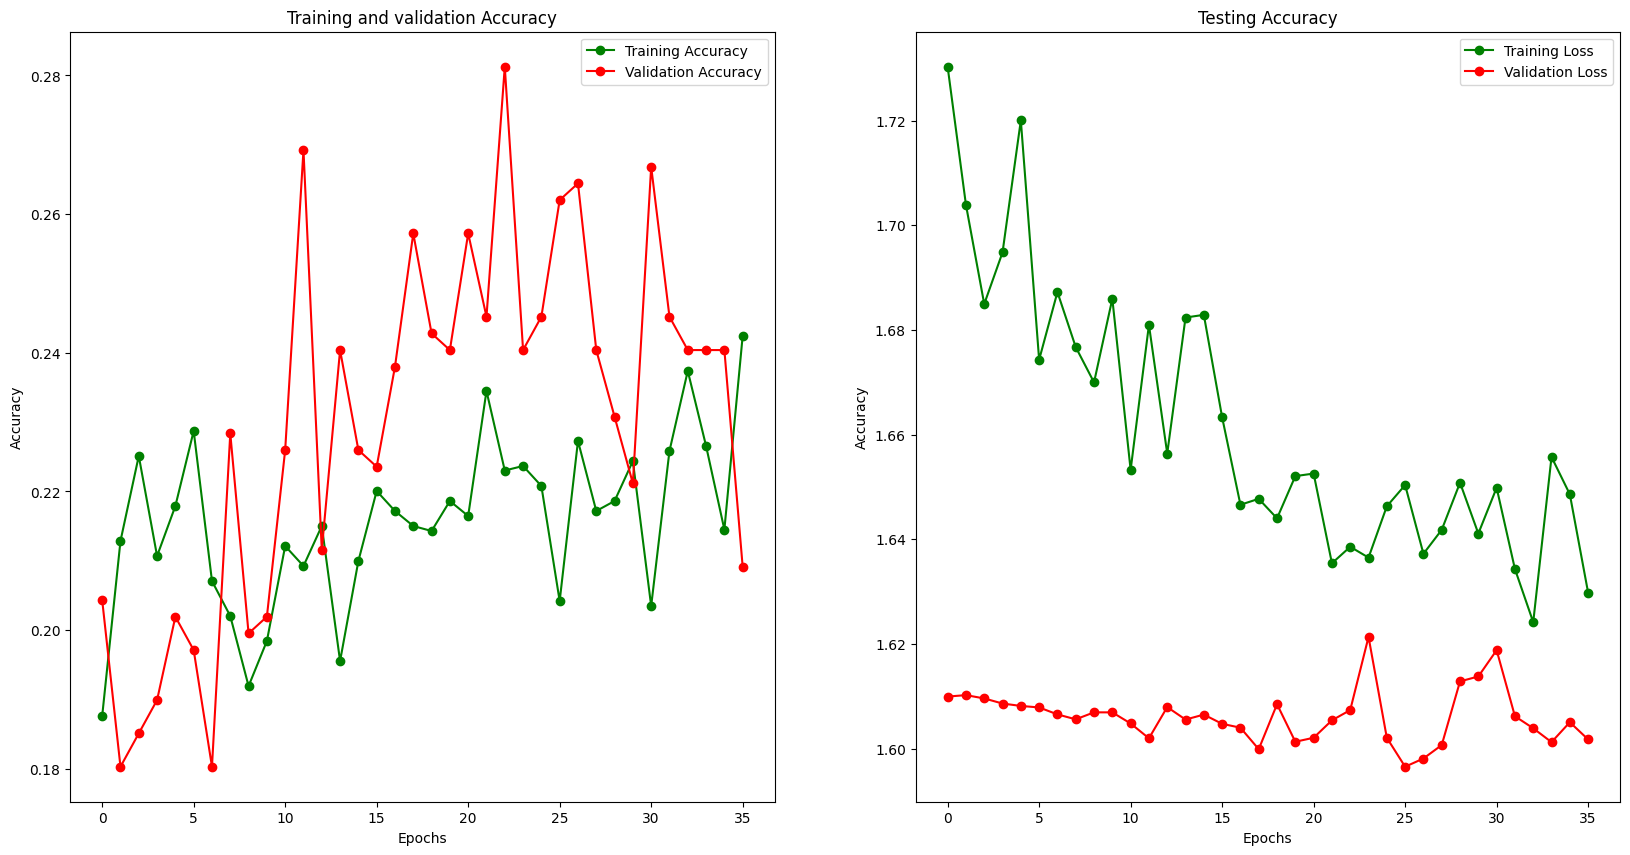

14/14 [==============================] - 6s 95ms/step


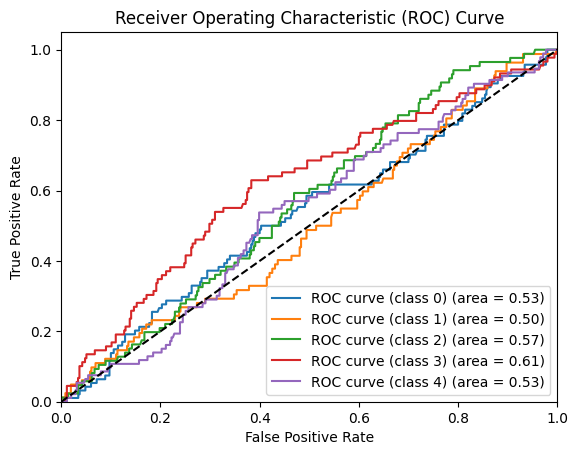

In [29]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 4 

In [30]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 93ms/step
Length of y_true: 422
Length of y_pred_classes: 422
Accuracy: 0.18
Precision: 0.15
Recall: 0.18
F1 Score: 0.15
F2 Score: 0.16
14/14 [==============================] - 1s 95ms/step
Length of y_true: 422
Length of y_pred: 422
Average AUC: 0.49


# Architecture No 5

In [31]:
# Load the EfficientNetV2L model pretrained on ImageNet
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [32]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-08 15:40:24.979889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 [==============================] - ETA: 0s - loss: 1.7106 - accuracy: 0.2063

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 50s 585ms/step - loss: 1.7106 - accuracy: 0.2063 - val_loss: 1.6088 - val_accuracy: 0.1947
Epoch 2/50
44/44 [==============================] - 19s 423ms/step - loss: 1.7285 - accuracy: 0.2071 - val_loss: 1.6093 - val_accuracy: 0.1851
Epoch 3/50
44/44 [==============================] - 21s 478ms/step - loss: 1.6891 - accuracy: 0.2179 - val_loss: 1.6087 - val_accuracy: 0.2067
Epoch 4/50
44/44 [==============================] - 21s 481ms/step - loss: 1.6885 - accuracy: 0.2006 - val_loss: 1.6078 - val_accuracy: 0.1899
Epoch 5/50
44/44 [==============================] - 21s 474ms/step - loss: 1.7010 - accuracy: 0.2042 - val_loss: 1.6072 - val_accuracy: 0.1923
Epoch 6/50
44/44 [==============================] - 21s 479ms/step - loss: 1.7028 - accuracy: 0.2049 - val_loss: 1.6060 - val_accuracy: 0.1995
Epoch 7/50
44/44 [==============================] - 22s 489ms/step - loss: 1.6812 - accuracy: 0.2179 - val_loss: 1.6053 - val_accuracy: 0.2091
Epoch 8/50

In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 2s 107ms/step - loss: 1.6003 - accuracy: 0.2387
Test accuracy: 0.24


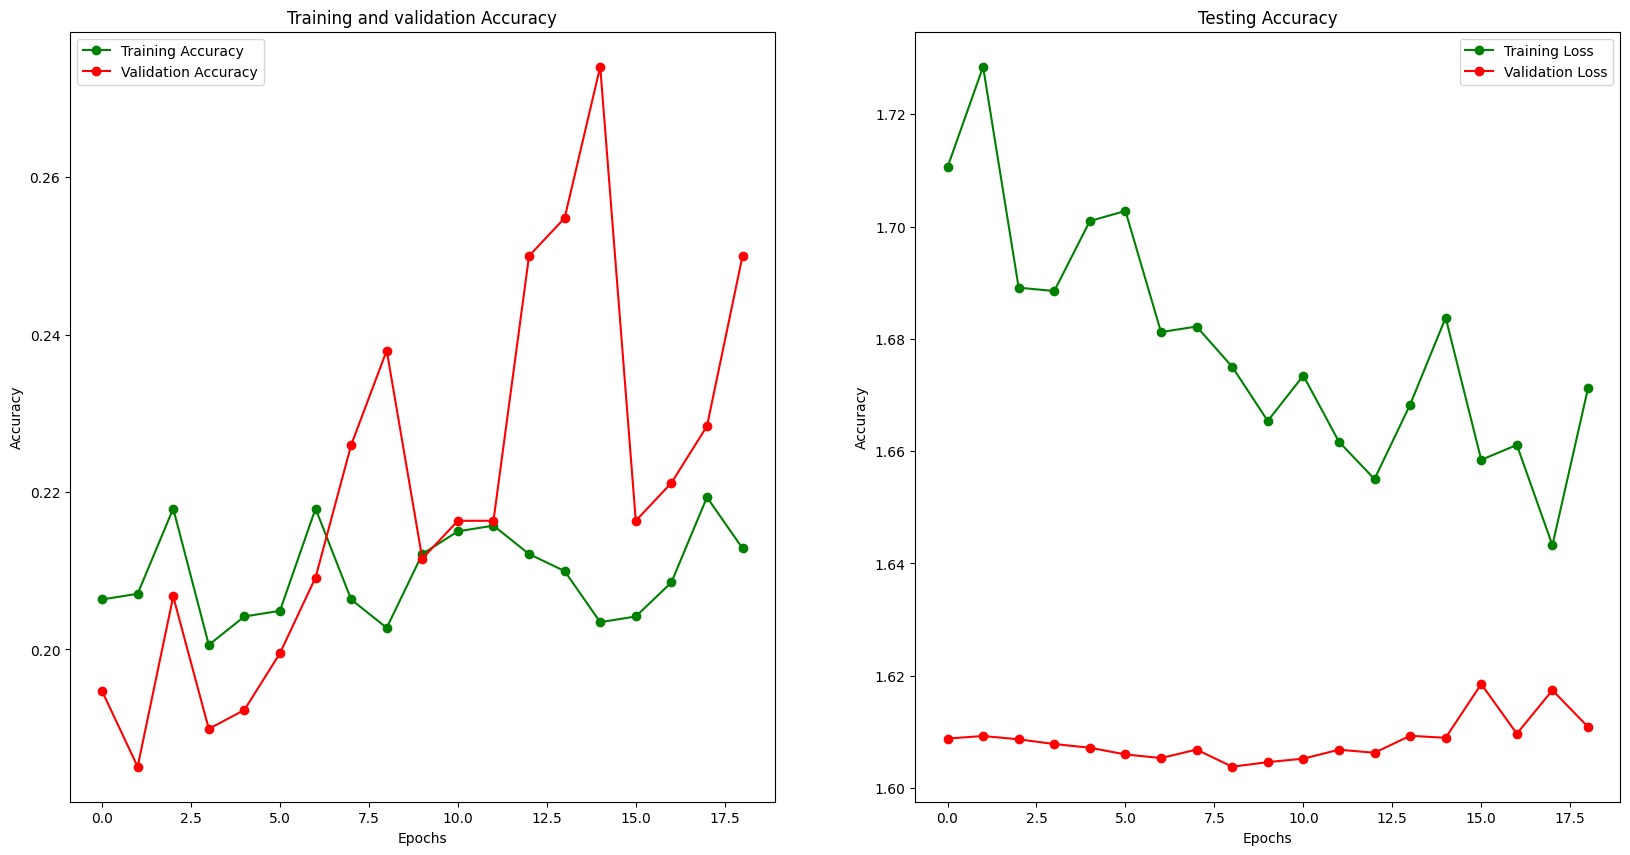

14/14 [==============================] - 8s 97ms/step


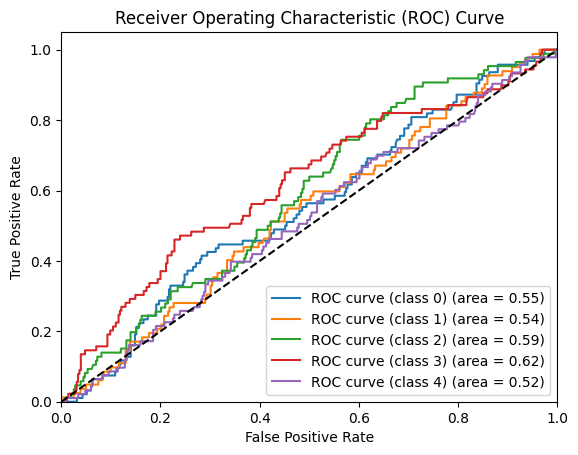

In [34]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 5

In [35]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 93ms/step
Length of y_true: 422
Length of y_pred_classes: 422
Accuracy: 0.18
Precision: 0.17
Recall: 0.18
F1 Score: 0.14
F2 Score: 0.16
14/14 [==============================] - 1s 95ms/step
Length of y_true: 422
Length of y_pred: 422
Average AUC: 0.51


# Architecture No 6

In [36]:
# Load the EfficientNetV2L model pretrained on ImageNet
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [37]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-08 15:47:30.179998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 [==============================] - ETA: 0s - loss: 1.7077 - accuracy: 0.2345

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 50s 588ms/step - loss: 1.7077 - accuracy: 0.2345 - val_loss: 1.6090 - val_accuracy: 0.2043
Epoch 2/50
44/44 [==============================] - 22s 488ms/step - loss: 1.6839 - accuracy: 0.2085 - val_loss: 1.6087 - val_accuracy: 0.1971
Epoch 3/50
44/44 [==============================] - 21s 485ms/step - loss: 1.6921 - accuracy: 0.2193 - val_loss: 1.6081 - val_accuracy: 0.2043
Epoch 4/50
44/44 [==============================] - 22s 492ms/step - loss: 1.6600 - accuracy: 0.2323 - val_loss: 1.6080 - val_accuracy: 0.2115
Epoch 5/50
44/44 [==============================] - 21s 479ms/step - loss: 1.6783 - accuracy: 0.2071 - val_loss: 1.6070 - val_accuracy: 0.2452
Epoch 6/50
44/44 [==============================] - 19s 420ms/step - loss: 1.6661 - accuracy: 0.1962 - val_loss: 1.6072 - val_accuracy: 0.2139
Epoch 7/50
44/44 [==============================] - 21s 481ms/step - loss: 1.6543 - accuracy: 0.2150 - val_loss: 1.6068 - val_accuracy: 0.2260
Epoch 8/50

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 2s 105ms/step - loss: 1.5982 - accuracy: 0.2387
Test accuracy: 0.24


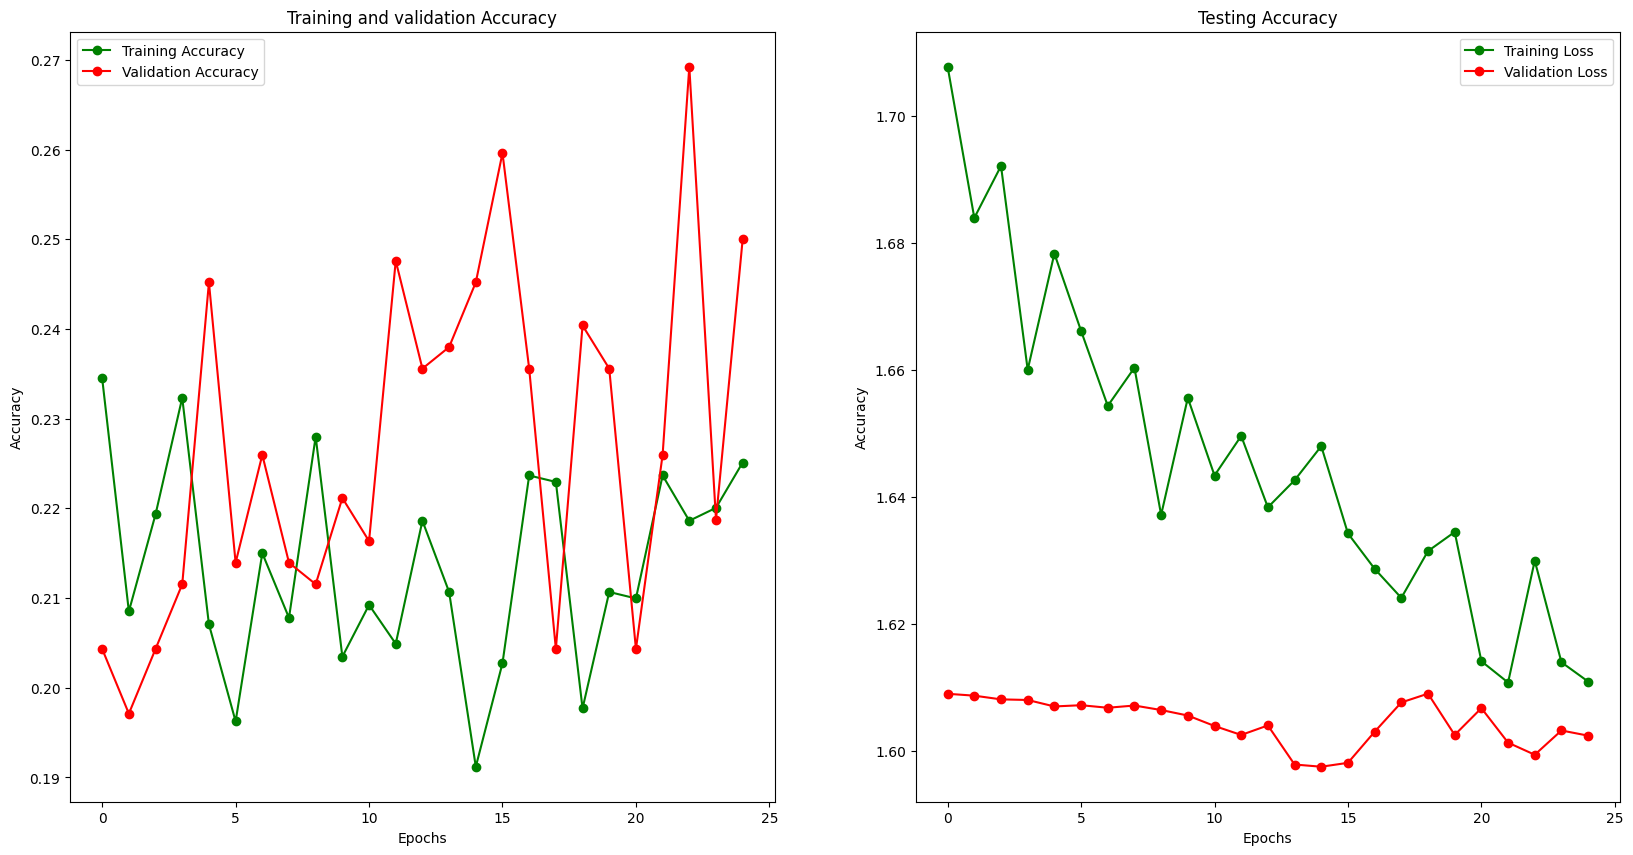

14/14 [==============================] - 8s 97ms/step


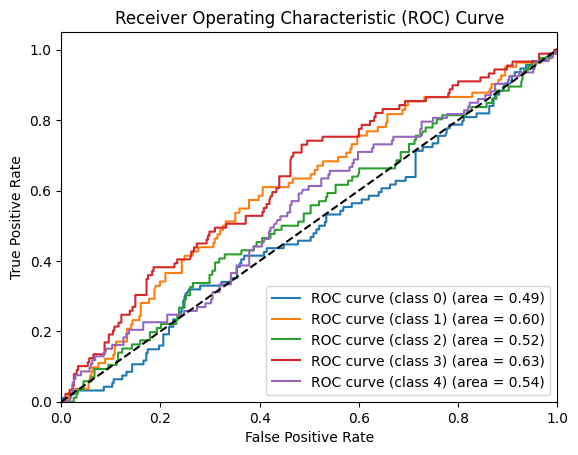

In [39]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 6

In [40]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 94ms/step
Length of y_true: 422
Length of y_pred_classes: 422
Accuracy: 0.22
Precision: 0.39
Recall: 0.22
F1 Score: 0.18
F2 Score: 0.20
14/14 [==============================] - 1s 95ms/step
Length of y_true: 422
Length of y_pred: 422
Average AUC: 0.52


# Architecture No 7

In [41]:
# Load the EfficientNetV2L model pretrained on ImageNet
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(1024, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [42]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-08 15:56:43.170287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 [==============================] - ETA: 0s - loss: 1.7231 - accuracy: 0.2056

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 50s 592ms/step - loss: 1.7231 - accuracy: 0.2056 - val_loss: 1.6088 - val_accuracy: 0.2284
Epoch 2/50
44/44 [==============================] - 19s 420ms/step - loss: 1.7163 - accuracy: 0.2136 - val_loss: 1.6090 - val_accuracy: 0.2284
Epoch 3/50
44/44 [==============================] - 21s 482ms/step - loss: 1.7031 - accuracy: 0.2251 - val_loss: 1.6075 - val_accuracy: 0.2476
Epoch 4/50
44/44 [==============================] - 21s 481ms/step - loss: 1.7130 - accuracy: 0.2157 - val_loss: 1.6073 - val_accuracy: 0.2572
Epoch 5/50
44/44 [==============================] - 21s 481ms/step - loss: 1.6704 - accuracy: 0.2309 - val_loss: 1.6072 - val_accuracy: 0.2163
Epoch 6/50
44/44 [==============================] - 21s 487ms/step - loss: 1.6772 - accuracy: 0.2186 - val_loss: 1.6058 - val_accuracy: 0.2188
Epoch 7/50
44/44 [==============================] - 21s 481ms/step - loss: 1.6700 - accuracy: 0.1991 - val_loss: 1.6057 - val_accuracy: 0.2308
Epoch 8/50

In [43]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

14/14 [==============================] - 2s 108ms/step - loss: 1.5908 - accuracy: 0.2658
Test accuracy: 0.27


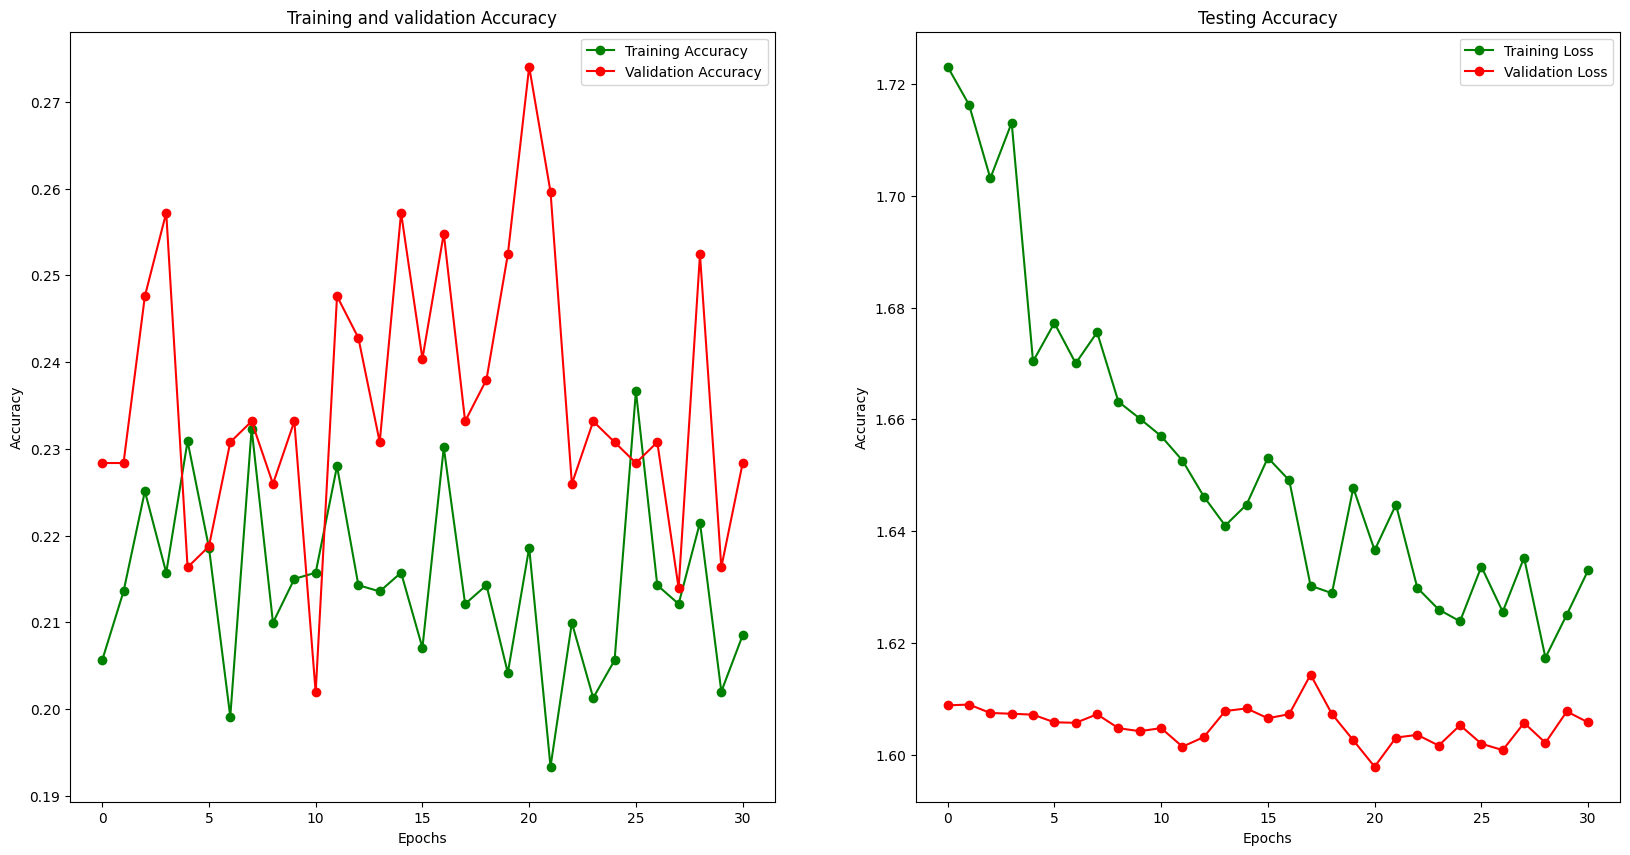

14/14 [==============================] - 8s 96ms/step


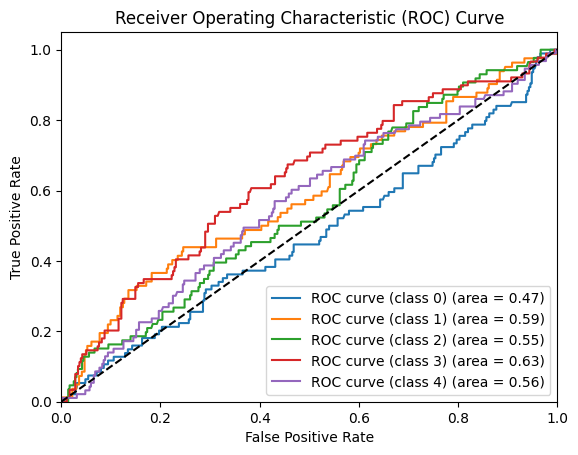

In [44]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 7

In [45]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

14/14 [==============================] - 1s 94ms/step
Length of y_true: 422
Length of y_pred_classes: 422
Accuracy: 0.18
Precision: 0.18
Recall: 0.18
F1 Score: 0.16
F2 Score: 0.17
14/14 [==============================] - 1s 95ms/step
Length of y_true: 422
Length of y_pred: 422
Average AUC: 0.53
